In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# gaussian kernel 
def gaussian_kernel(x, sigma):
    n = len(x)
    K = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            K[i, j] = np.exp(-((x[i] - x[j]) ** 2).sum() / sigma**2)
    return K

# def incomplete_cholesky(K, eta):
#     n = len(K)
#     R = np.zeros_like(K)
#     d = np.diag(K).copy()
#     j = 0

#     while True:
#         a = np.max(d)
#         if a <= eta:
#             break
#         i = np.argmax(d)
#         nu = np.sqrt(a)

#         if j == 0:
#             R[j, :] = K[i, :] / nu
#         else:
#             R[j, :] = (K[i, :] - R[:j, :].T @ R[:j, i]) / nu

#         d -= R[j, :]**2
#         j += 1

#     return R[:j, :]
def incomplete_cholesky(K, eta):
    dim = K.shape[0]
    R = np.zeros((dim,dim))
    d = np.diag(K).copy()
    I = []
    j = 0

    while True:
        a = np.max(d)
        if a <= eta:
            break
        pivot_index = np.argmax(d)
        I.append(pivot_index)

        nu = np.sqrt(a)

        for i in range(dim):
            R[j, i] = (K[I[j], i] - R[:j, i] @ R[:j, I[j]]) / nu
            d[i] -= R[j, i] ** 2
        j += 1

    R = R[:j, :]

    return R

def coco():
    # generate the data, with N samples
    np.random.seed(515)
    N = 200
    t = np.random.uniform(0, 2 * np.pi, N)
    n1 = np.random.normal(0, 0.01, N)
    n2 = np.random.normal(0, 0.01, N)
    x = np.sin(t) + n1
    y = np.cos(t) + n2

    plt.figure()
    plt.scatter(x, y)
    plt.title("Generated Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    # define the parameters for gaussian kernel and incomplete cholesky 
    sigma = 1
    eta = 1e-6

    # define K and L 
    K = gaussian_kernel(x, sigma)
    L = gaussian_kernel(y, sigma)
    H = np.eye(N) - np.ones((N, N)) / N
    K_tilde = H @ K @ H
    L_tilde = H @ L @ H
    # define zero blocks
    z = np.zeros((N, N))
    # define matrix for eigen-problem
    # A v = gamma * B v
    A = np.block([[z, K_tilde @ L_tilde / N],
                  [L_tilde @ K_tilde / N, z]])
    B = np.block([[K_tilde, z],
                  [z, L_tilde]])

    # incomplete Cholesky solution
    # apply QR decomputation on B -> R^T R
    R = incomplete_cholesky(B, eta)
    # A v = gamma * R.T * R v, let u = Rv -> v = inv(R)u
    # A inv(R)u = gamma * R.T * u
    # inv(R.T) A inv(R) u = gamma u
    C = np.linalg.pinv(R.T) @ A @ np.linalg.pinv(R)
    eigvals, eigvecs = np.linalg.eig(C)

    coco = np.abs(np.real(np.max(eigvals)))
    eigvecs_v = np.linalg.pinv(R) @ eigvecs[:, 0]
    alpha = eigvecs_v[:N]
    beta = eigvecs_v[N:]

    fx = K @ H @ alpha
    gx = L @ H @ beta

    plt.figure()
    plt.scatter(x, fx, s=15)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

    plt.figure()
    plt.scatter(y, gx, s=15)
    plt.xlabel("y")
    plt.ylabel("g(x)")
    plt.show()

    plt.figure()
    plt.scatter(fx, gx, s=15)
    plt.xlabel("f(x)")
    plt.ylabel("g(x)")
    plt.show()
    
    print("COCO value is:", coco)

def coco_method2():
    # generate the data, with N samples
    np.random.seed(515)
    N = 200
    t = np.random.uniform(0, 2 * np.pi, N)
    n1 = np.random.normal(0, 0.01, N)
    n2 = np.random.normal(0, 0.01, N)
    x = np.sin(t) + n1
    y = np.cos(t) + n2

    plt.figure()
    plt.scatter(x, y)
    plt.title("Generated Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    # define the parameters for gaussian kernel and incomplete cholesky 
    sigma = 1
    eta = 1e-6

    # define K and L 
    K = gaussian_kernel(x, sigma)
    L = gaussian_kernel(y, sigma)
    H = np.eye(N) - np.ones((N, N)) / N
    # incomplete cholesky on both K and L
    R = incomplete_cholesky(K, eta)
    S = incomplete_cholesky(L, eta)
    K_tilde = H @ K @ H
    L_tilde = H @ L @ H
    # define zero blocks
    z = np.zeros((N, N))
    # define matrix for eigen-problem
    # A v = gamma * B v here B is identity
    A = np.block([[z, R @ S.T / N],
                  [S @ R.T / N, z]])

    eigvals, eigvecs = np.linalg.eig(A)

    coco = np.abs(np.real(np.max(eigvals)))
    alpha = H @ np.linalg.pinv(R) @ eigvecs[:, N]
    beta = H @ np.linalg.pinv(S) @ eigvecs[N,2*N]
    # alpha = eigvecs_v[:N]
    # beta = eigvecs_v[N:]

    fx = K @ H @ alpha
    gx = L @ H @ beta

    plt.figure()
    plt.scatter(x, fx, s=15)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

    plt.figure()
    plt.scatter(y, gx, s=15)
    plt.xlabel("y")
    plt.ylabel("g(x)")
    plt.show()

    plt.figure()
    plt.scatter(fx, gx, s=15)
    plt.xlabel("f(x)")
    plt.ylabel("g(x)")
    plt.show()
    
    print("COCO value is:", coco)

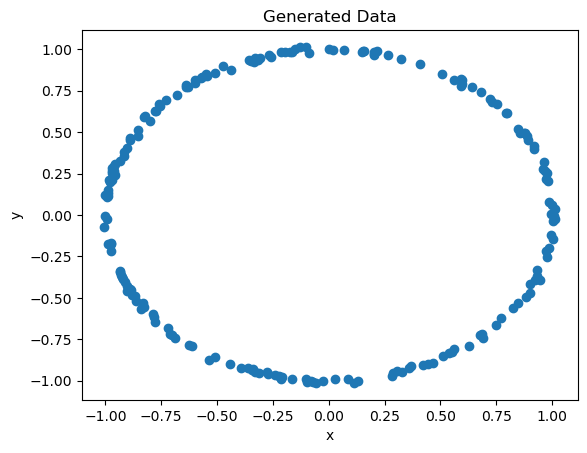

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 200 and the array at index 1 has size 9

In [4]:
coco_method2()

In [13]:
def cca():
    # generate the data, with N samples
    np.random.seed(515)
    N = 200
    t = np.random.uniform(0, 2 * np.pi, N)
    n1 = np.random.normal(0, 0.01, N)
    n2 = np.random.normal(0, 0.01, N)
    x = np.sin(t) + n1
    y = np.cos(t) + n2

    plt.figure()
    plt.scatter(x, y)
    plt.title("Generated Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()

    # define the parameters for gaussian kernel and incomplete cholesky 
    # code is same as coco but we have a regularization term KAPA
    sigma = 1
    eta = 1e-6
    kapa = 0.1
    # define K and L 
    K = gaussian_kernel(x, sigma)
    L = gaussian_kernel(y, sigma)
    H = np.eye(N) - np.ones((N, N)) / N
    K_tilde = H @ K @ H
    L_tilde = H @ L @ H

    # define zero blocks
    z = np.zeros((N, N))
    # define matrix for eigen-problem 
    # we modify B with regularization term 
    # A v = gamma * B v
    A = np.block([[z, K_tilde @ L_tilde / N],
                  [L_tilde @ K_tilde / N, z]])
    B = np.block([[K_tilde @ K_tilde + kapa * K_tilde, z],
                  [z, L_tilde @ L_tilde + kapa * L_tilde]])

    # apply QR decomputation on B -> R^T R
    R = incomplete_cholesky(B, eta)    
    C = np.linalg.pinv(R.T) @ A @ np.linalg.pinv(R)
    eigvals, eigvecs = np.linalg.eig(C)

    coco = np.abs(np.real(np.max(eigvals)))
    eigvecs_v = np.linalg.pinv(R) @ eigvecs[:, 0]
    alpha = eigvecs_v[:N]
    beta = eigvecs_v[N:]

    fx = K @ H @ alpha
    gx = L @ H @ beta

    plt.figure()
    plt.scatter(x, fx, s=15)
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.show()

    plt.figure()
    plt.scatter(y, gx, s=15)
    plt.xlabel("y")
    plt.ylabel("g(x)")
    plt.show()

    plt.figure()
    plt.scatter(fx, gx, s=15)
    plt.xlabel("f(x)")
    plt.ylabel("g(x)")
    plt.show()



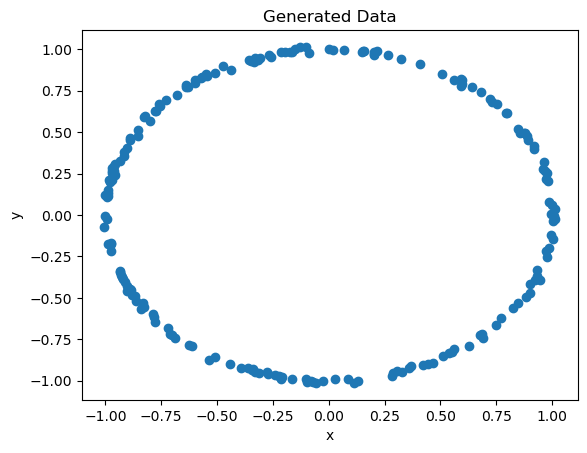

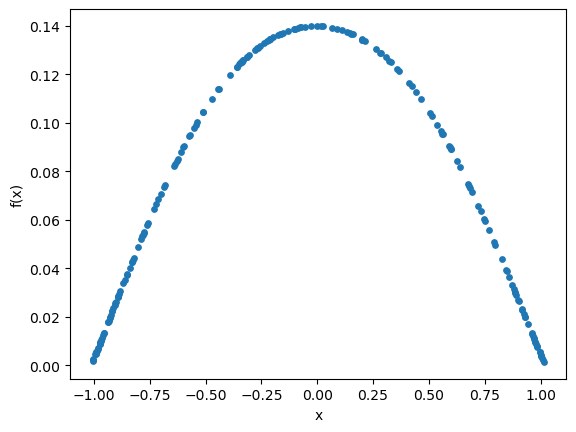

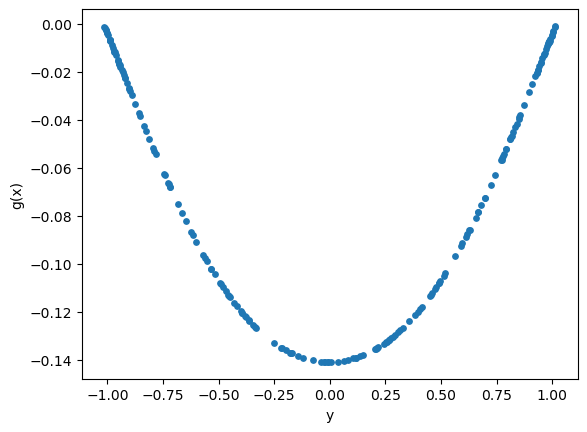

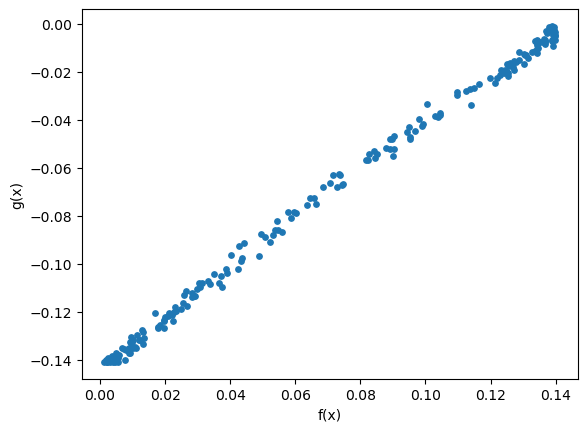

In [14]:
cca()